In [1]:
import sys
sys.path.append('../..')

In [2]:
from DLBio import pt_training
import ds_ear
from torchvision.models.mobilenet import mobilenet_v2
import torch.nn as nn
from DLBio.pytorch_helpers import get_device, get_num_params
from DLBio.helpers import check_mkdir
from DLBio.pt_train_printer import Printer
import json
import matplotlib.pyplot as plt
from os.path import join

In [3]:
class Classification(pt_training.ITrainInterface):
    def __init__(self, model, device):
        self.model = model
        self.xent_loss = nn.CrossEntropyLoss()
        self.metrics = {
            'acc': accuracy
        }
        self.d = device

    def train_step(self, sample):
        images, targets = sample[0].to(self.d), sample[1].to(self.d)
        pred = self.model(images)

        loss = self.xent_loss(pred, targets)
        metrics = dict()

        metrics.update({k: v(pred, targets) for k, v in self.metrics.items()})

        return loss, metrics


def accuracy(y_pred, y_true):
    _, y_pred = y_pred.max(1)  # grab class predictions
    return (y_pred == y_true).float().mean().item()

In [4]:
# define constants
FOLDER = './class_sample'
BATCH_SIZE = 32
NUM_WORKERS = 4 # set to zero, if you want to run a debugger
OPT_TYPE = 'Adam'
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.00001
EPOCHS = 9
LR_STEPS = 3
DO_EARLY_STOPPING = True
STOP_AFTER = 10
ES_METRIC = 'val_acc'
SAVE_INTERVALL = -1
PRINT_FREQUENCY = 500 # print every 500 batches
SEED = 0

# use seeds to ensure comparable results ()
pt_training.set_random_seed(SEED)

Setting seed: 0


<function DLBio.pt_training.set_random_seed.<locals>._init_fn(worker_id)>

In [5]:
device = get_device()
print(device)
model = mobilenet_v2(pretrained=True)
# cifar only has 10 classes
model = model.to(device)
#model = model.to('cuda:0')

cuda:0


In [6]:
check_mkdir(FOLDER, is_dir=True)
model_out = join(FOLDER, 'model.pt')
log_file = join(FOLDER, 'log.json')

# write some model specs
with open(join(FOLDER, 'model_specs.json'), 'w') as file:
    json.dump({
        'num_trainable': float(get_num_params(model, True)),
        'num_params': float(get_num_params(model, False))
    }, file)

dl_train = ds_ear.get_dataloader(
            is_train=True,
            batch_size=BATCH_SIZE,
            num_workers=NUM_WORKERS
        )

dl_test = ds_ear.get_dataloader(
            is_train=False,
            batch_size=BATCH_SIZE,
            num_workers=NUM_WORKERS
        )

optimizer = pt_training.get_optimizer(
        'Adam', model.parameters(),
        LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    )

if LR_STEPS > 0:
    scheduler = pt_training.get_scheduler(
            LR_STEPS, EPOCHS, optimizer)

if DO_EARLY_STOPPING:
    assert SAVE_INTERVALL == -1
    early_stopping = pt_training.EarlyStopping(
            ES_METRIC, get_max=True, epoch_thres=STOP_AFTER
        )
else:
    early_stopping = None
    
train_interface = Classification(model, device)

training = pt_training.Training(
        optimizer, dl_train, train_interface,
        scheduler=scheduler, printer=Printer(PRINT_FREQUENCY, log_file),
        save_path=model_out, save_steps=SAVE_INTERVALL,
        val_data_loader=dl_test,
        early_stopping=early_stopping
    )

training(EPOCHS)

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100']
['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043

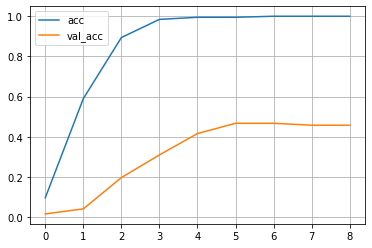

In [7]:
with open(log_file, 'r') as file:
    log = json.load(file)

plt.plot(log['acc'], label='acc')
plt.plot(log['val_acc'], label='val_acc')

plt.legend()
plt.grid()